# Performance Baselines

In [1]:
import watermark
import pandas as pd
import numpy as np
import datetime
import random
import copy
import os
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
import ray
from tqdm import tqdm
import matplotlib.pyplot as plt 

%reload_ext watermark
%watermark -p xgboost,pandas,numpy,scikit-learn
!python --version

xgboost     : not installed
pandas      : 1.2.4
numpy       : 1.20.1
scikit-learn: 0.24.1

Python 3.8.8


## Dataset

In [2]:
# Read ratings df
path = "data_small"
use_large = False
if (use_large):
    path = "data_large"
    ratings = pd.read_csv('./' + path + '/ratings.csv')[:5000000]
else:
    ratings = pd.read_csv('./' + path + '/ratings.csv')

movies = pd.read_csv('./' + path + '/movies.csv')

print(ratings)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]


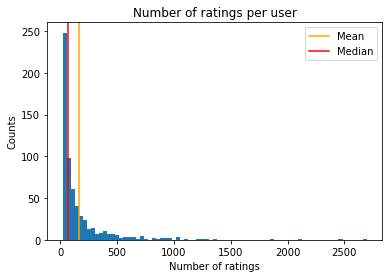

Minimum: 20
25th Percentile: 35.0
Median: 70.5
Mean: 165.30491803278687
75th Percentile: 168.0
Maximum: 2698


In [3]:
x = ratings.userId.unique()

data = ratings.pivot(index = "userId", columns = "movieId", values = "rating")
y = data.count(axis = 1, numeric_only = True)
del data

mean = np.mean(y)
median = np.median(y)
maximum = np.max(y)
minimum = np.min(y)
q1 = np.percentile(y, 25, interpolation = 'midpoint')
q3 = np.percentile(y, 75, interpolation = 'midpoint')

plt.hist(y, bins = 75)
plt.axvline(x=mean, color = "orange", label="Mean")
plt.axvline(x=median, color = "red", label = "Median")
plt.title("Number of ratings per user")
plt.xlabel("Number of ratings")
plt.ylabel("Counts")
plt.legend(loc="upper right")
plt.savefig("num_user_ratings.jpg")
plt.show()

print("Minimum:", minimum)
print("25th Percentile:", q1)
print("Median:", median)
print("Mean:", mean)
print("75th Percentile:", q3)
print("Maximum:", maximum)

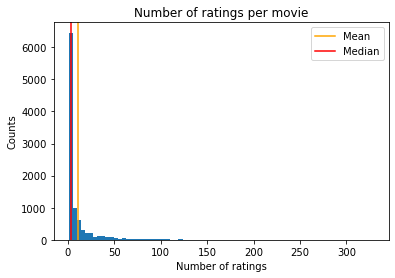

Minimum: 1
25th Percentile: 1.0
Median: 3.0
Mean: 10.369806663924312
75th Percentile: 9.0
Maximum: 329


In [4]:
data = ratings.pivot(index = "userId", columns = "movieId", values = "rating")
y = data.count(axis = 0, numeric_only = True)
del data

mean = np.mean(y)
median = np.median(y)
maximum = np.max(y)
minimum = np.min(y)
q1 = np.percentile(y, 25, interpolation = 'midpoint')
q3 = np.percentile(y, 75, interpolation = 'midpoint')

plt.hist(y, bins = 75)
plt.axvline(x=mean, color = "orange", label="Mean")
plt.axvline(x=median, color = "red", label = "Median")
plt.title("Number of ratings per movie")
plt.xlabel("Number of ratings")
plt.ylabel("Counts")
plt.legend(loc="upper right")
plt.savefig("num_movie_ratings.jpg")
plt.show()

print("Minimum:", minimum)
print("25th Percentile:", q1)
print("Median:", median)
print("Mean:", mean)
print("75th Percentile:", q3)
print("Maximum:", maximum)

In [5]:
# Delete movies with fewer than 25 ratings
start = datetime.datetime.now()

data = ratings.pivot(index = "userId", columns = "movieId", values = "rating")
to_del = list()
counts = data.count(axis = 0, numeric_only = True)
for i in tqdm(data.columns.values):
    if (counts[i] < 25):
        to_del.append(i)
ratings = ratings[~(ratings.movieId.isin(to_del))]
del data

print('Time removing movies: {}'.format(datetime.datetime.now()-start))
print("There were", len(to_del), "movies with fewer than 25 ratings. They have been removed from the dataset.")

100%|██████████████████████████████████████████████████████████████████████████| 9724/9724 [00:00<00:00, 180688.69it/s]

Time removing movies: 0:00:00.165840
There were 8674 movies with fewer than 25 ratings. They have been removed from the dataset.


In [6]:
# Delete users with fewer than 20 ratings
start = datetime.datetime.now()

data = ratings.pivot(index = "userId", columns = "movieId", values = "rating")
print(data.shape)
to_del = list()
counts = data.count(axis = 1, numeric_only = True)
for i in tqdm(data.index.values):
    if (counts[i] < 20):
        to_del.append(i)
ratings = ratings[~(ratings.userId.isin(to_del))]
del data

print('Time removing users: {}'.format(datetime.datetime.now()-start))
print("There were", len(to_del), "users with fewer than 20 ratings. They have been removed from the dataset.")

100%|████████████████████████████████████████████████████████████████████████████| 610/610 [00:00<00:00, 202207.02it/s]

(610, 1050)
Time removing users: 0:00:00.097713
There were 61 users with fewer than 20 ratings. They have been removed from the dataset.


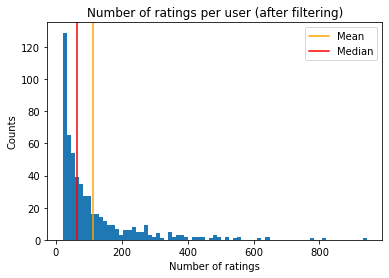

Minimum: 20
25th Percentile: 34.0
Median: 64.0
Mean: 112.23861566484517
75th Percentile: 135.0
Maximum: 944


In [7]:
x = ratings.userId.unique()

data = ratings.pivot(index = "userId", columns = "movieId", values = "rating")
y = data.count(axis = 1, numeric_only = True)
del data

mean = np.mean(y)
median = np.median(y)
maximum = np.max(y)
minimum = np.min(y)
q1 = np.percentile(y, 25, interpolation = 'midpoint')
q3 = np.percentile(y, 75, interpolation = 'midpoint')

plt.hist(y, bins = 75)
plt.axvline(x=mean, color = "orange", label="Mean")
plt.axvline(x=median, color = "red", label = "Median")
plt.title("Number of ratings per user (after filtering)")
plt.xlabel("Number of ratings")
plt.ylabel("Counts")
plt.legend(loc="upper right")
plt.savefig("num_user_ratings_filtered.jpg")
plt.show()

print("Minimum:", minimum)
print("25th Percentile:", q1)
print("Median:", median)
print("Mean:", mean)
print("75th Percentile:", q3)
print("Maximum:", maximum)

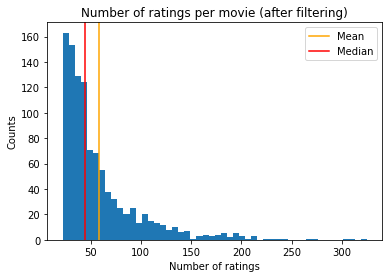

Minimum: 22
25th Percentile: 32.0
Median: 44.0
Mean: 58.684761904761906
75th Percentile: 68.0
Maximum: 325


In [8]:
data = ratings.pivot(index = "userId", columns = "movieId", values = "rating")
y = data.count(axis = 0, numeric_only = True)
del data

mean = np.mean(y)
median = np.median(y)
maximum = np.max(y)
minimum = np.min(y)
q1 = np.percentile(y, 25, interpolation = 'midpoint')
q3 = np.percentile(y, 75, interpolation = 'midpoint')

plt.hist(y, bins = 50)
plt.axvline(x=mean, color = "orange", label="Mean")
plt.axvline(x=median, color = "red", label = "Median")
plt.title("Number of ratings per movie (after filtering)")
plt.xlabel("Number of ratings")
plt.ylabel("Counts")
plt.legend(loc="upper right")
plt.savefig("num_movie_ratings_filtered.jpg")
plt.show()

print("Minimum:", minimum)
print("25th Percentile:", q1)
print("Median:", median)
print("Mean:", mean)
print("75th Percentile:", q3)
print("Maximum:", maximum)

In [9]:
# Removes users with fewer than 20 ratings
# To be used when the userXmovie matrix is too large
"""
# Removes users who no longer have 20 ratings
@ray.remote
def insufficient_ratings(dataset, user):
    user_ratings = sum(dataset.userId == user)
    if (user_ratings < 20):
        return user
    return -1

def to_iterator(obj_ids):
    while obj_ids:
        done, obj_ids = ray.wait(obj_ids)
        yield ray.get(done[0])

dat = ray.put(ratings)
obj_ids = [insufficient_ratings.remote(dat, user) for user in ratings.userId.unique()]
results = []
for x in tqdm(to_iterator(obj_ids), total = len(obj_ids)):
    if x > -1:
        results.append(x)

ratings = ratings.loc[~(ratings.userId.isin(results))]

del dat
        
print("There were", len(results), "users with fewer than 20 ratings. They have been removed from the dataset.")
"""

'\n# Removes users who no longer have 20 ratings\n@ray.remote\ndef insufficient_ratings(dataset, user):\n    user_ratings = sum(dataset.userId == user)\n    if (user_ratings < 20):\n        return user\n    return -1\n\ndef to_iterator(obj_ids):\n    while obj_ids:\n        done, obj_ids = ray.wait(obj_ids)\n        yield ray.get(done[0])\n\ndat = ray.put(ratings)\nobj_ids = [insufficient_ratings.remote(dat, user) for user in ratings.userId.unique()]\nresults = []\nfor x in tqdm(to_iterator(obj_ids), total = len(obj_ids)):\n    if x > -1:\n        results.append(x)\n\nratings = ratings.loc[~(ratings.userId.isin(results))]\n\ndel dat\n        \nprint("There were", len(results), "users with fewer than 20 ratings. They have been removed from the dataset.")\n'

In [10]:
# Only keep 20 ratings per user
#ratings = ratings.groupby("userId").sample(n=20, random_state=1)

In [11]:
# Get a list of all genres
genres_set = set()
for string in tqdm(movies.genres):
    genres_set.update(string.split('|'))
#genres.remove('(no genres listed)')
genres = sorted(genres_set)
print(genres)

100%|██████████████████████████████████████████████████████████████████████████| 9742/9742 [00:00<00:00, 751395.91it/s]

['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [12]:
# Add one-hot encoding for movie genres
for genre in genres:
    ratings[genre] = False

for movie in tqdm(ratings.movieId.unique()):
    for genre in movies.genres[movies.loc[movies.movieId == movie].index[0]].split('|'):
        ratings.loc[ratings.movieId == movie, [genre]] = True

100%|█████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:04<00:00, 218.72it/s]


In [13]:
# Note that GroupShuffleSplit allows us to have distinct users in the training, validation, and test sets

# Split into 80-20 training - testing split
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42).split(ratings, groups=ratings.userId))

train_val = ratings.iloc[train_inds].copy()
test = ratings.iloc[test_inds].copy()

# Split into 80-20 training - validation split
train_inds, val_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42).split(train_val, groups=train_val.userId))

training = train_val.iloc[train_inds].copy()
validation = train_val.iloc[val_inds].copy()

print('Train/Valid/Test sizes:', training.shape[0], validation.shape[0], test.shape[0])
print('Train/Valid/Test users:', len(training.userId.unique()), len(validation.userId.unique()), len(test.userId.unique()))

Train/Valid/Test sizes: 38700 10195 12724
Train/Valid/Test users: 351 88 110


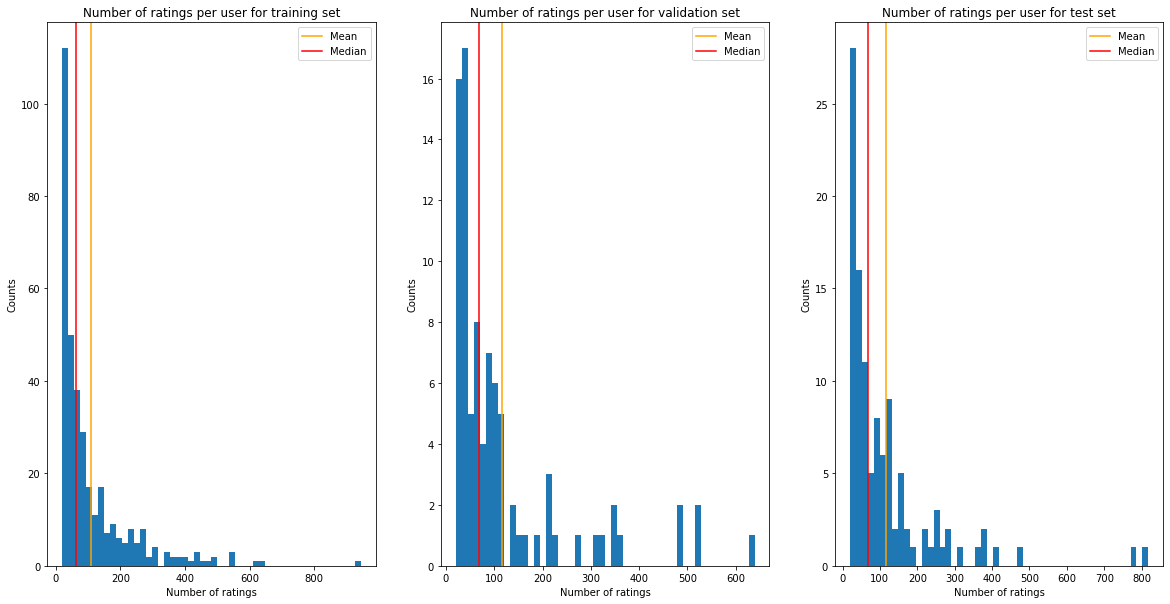

In [14]:
# Training set
plt.figure(figsize=[20, 10])

data = training.pivot(index = "userId", columns = "movieId", values = "rating")
y = data.count(axis = 1, numeric_only = True)

mean = np.mean(y)
median = np.median(y)

del data

plt.subplot(1, 3, 1)
plt.hist(y, bins = 50)
plt.axvline(x=mean, color = "orange", label="Mean")
plt.axvline(x=median, color = "red", label = "Median")
plt.title("Number of ratings per user for training set")
plt.xlabel("Number of ratings")
plt.ylabel("Counts")
plt.legend(loc="upper right")

# Validation set
data = validation.pivot(index = "userId", columns = "movieId", values = "rating")
y = data.count(axis = 1, numeric_only = True)

mean = np.mean(y)
median = np.median(y)

del data

plt.subplot(1, 3, 2)
plt.hist(y, bins = 50)
plt.axvline(x=mean, color = "orange", label="Mean")
plt.axvline(x=median, color = "red", label = "Median")
plt.title("Number of ratings per user for validation set")
plt.xlabel("Number of ratings")
plt.ylabel("Counts")
plt.legend(loc="upper right")

# Test set
data = test.pivot(index = "userId", columns = "movieId", values = "rating")
y = data.count(axis = 1, numeric_only = True)

mean = np.mean(y)
median = np.median(y)

del data

plt.subplot(1, 3, 3)
plt.hist(y, bins = 50)
plt.axvline(x=mean, color = "orange", label="Mean")
plt.axvline(x=median, color = "red", label = "Median")
plt.title("Number of ratings per user for test set")
plt.xlabel("Number of ratings")
plt.ylabel("Counts")
plt.legend(loc="upper right")

plt.show()

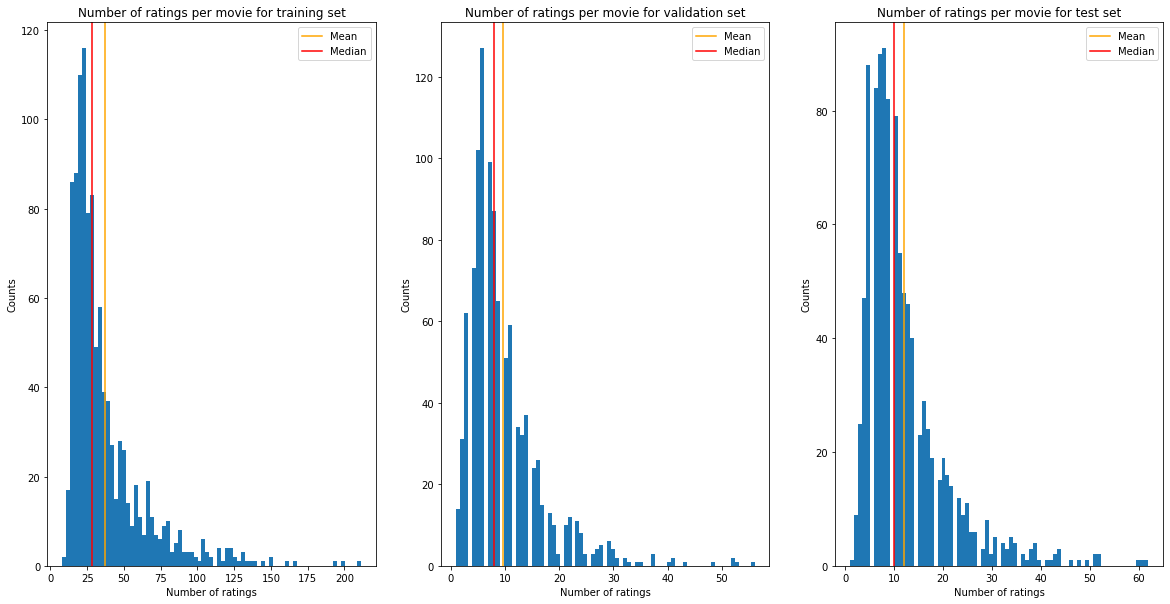

In [15]:
# Training set
plt.figure(figsize=[20, 10])

data = training.pivot(index = "userId", columns = "movieId", values = "rating")
y = data.count(axis = 0, numeric_only = True)

mean = np.mean(y)
median = np.median(y)

del data

plt.subplot(1, 3, 1)
plt.hist(y, bins = 75)
plt.axvline(x=mean, color = "orange", label="Mean")
plt.axvline(x=median, color = "red", label = "Median")
plt.title("Number of ratings per movie for training set")
plt.xlabel("Number of ratings")
plt.ylabel("Counts")
plt.legend(loc="upper right")

# Validation set
data = validation.pivot(index = "userId", columns = "movieId", values = "rating")
y = data.count(axis = 0, numeric_only = True)

mean = np.mean(y)
median = np.median(y)

del data


plt.subplot(1, 3, 2)
plt.hist(y, bins = 75)
plt.axvline(x=mean, color = "orange", label="Mean")
plt.axvline(x=median, color = "red", label = "Median")
plt.title("Number of ratings per movie for validation set")
plt.xlabel("Number of ratings")
plt.ylabel("Counts")
plt.legend(loc="upper right")

# Test set
data = test.pivot(index = "userId", columns = "movieId", values = "rating")
y = data.count(axis = 0, numeric_only = True)

mean = np.mean(y)
median = np.median(y)

del data

plt.subplot(1, 3, 3)
plt.hist(y, bins = 75)
plt.axvline(x=mean, color = "orange", label="Mean")
plt.axvline(x=median, color = "red", label = "Median")
plt.title("Number of ratings per movie for test set")
plt.xlabel("Number of ratings")
plt.ylabel("Counts")
plt.legend(loc="upper right")

plt.show()

In [16]:
# As it is, this will take the 10 most recent ratings for a user to use for prediction
# Commented out sections allow random ratings to be taken

@ray.remote
def prepare_helper(user, dataset):
    #random.seed(1)
    user_ratings = dataset.loc[dataset.userId == user]
                               
    # Randomly select 10 movies to remove
    #selected_movies = random.sample(range(0, user_ratings.shape[0]), 10)
    #selected_movies = random.choices(list(user_ratings.movieId), k=10)
                               
    # This will select the 10 most recent ratings for this user
    selected_movies = user_ratings.sort_values(by = "timestamp", ascending = False).movieId.values[0:10]
    
    # Add the removed movies to the removed dataframe
    removed_movies = user_ratings[user_ratings.movieId.isin(selected_movies)]
    
    return removed_movies

In [17]:
# This function takes in either the validation or training set
# Removes the most recent 10 ratings for each user, and returns them as removed_movies
# Returns the original dataset with the ratings to predict removed as new_movies
def prepare_data(dataset):
    # For validation and test data, remove 10 rated movies to be predicted
    removed_movies = pd.DataFrame(columns = dataset.columns)
    # Iterate over each user
    
    def to_iterator(obj_ids):
        while obj_ids:
            done, obj_ids = ray.wait(obj_ids)
            yield ray.get(done[0])
    dat = ray.put(dataset)
    obj_ids = [prepare_helper.remote(user, dat) for user in dataset["userId"].unique()]
    results = []
    for x in tqdm(to_iterator(obj_ids), total = len(obj_ids)):
        results.append(x)
    
    # Combine removed movies:
    for result in tqdm(results):
        removed_movies = pd.concat([removed_movies, result])
        
    # Remove all of the user-movie combinations in removed_moviews from dataset
    new_movies = pd.merge(dataset, removed_movies, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    del dat
    
    return removed_movies, new_movies

In [18]:
# Get the proper splits for the validation and testing sets
if (os.path.isfile('./' + path + '/validation_removed_tmp.csv') and os.path.isfile('./' + path + '/validation_new.csv')):
    print("Validation set already exists" )
    validation_removed = pd.read_csv('./' + path + '/validation_removed_tmp.csv')
    validation_new = pd.read_csv('./' + path + '/validation_new.csv')
else:
    start = datetime.datetime.now()
    ray.init(ignore_reinit_error=True)
    validation_removed, validation_new = prepare_data(validation)
    print('Time building validation set: {}'.format(datetime.datetime.now()-start))
    validation_removed.to_csv('./' + path + '/validation_removed_tmp.csv')
    validation_new.to_csv('./' + path + '/validation_new.csv')

if (os.path.isfile('./' + path + '/test_removed_tmp.csv') and os.path.isfile('./' + path + '/test_new.csv')):
    print("Test set already exists" )
    test_removed = pd.read_csv('./' + path + '/test_removed_tmp.csv')
    test_new = pd.read_csv('./' + path + '/test_new.csv')                                                                
else:
    start = datetime.datetime.now()
    ray.init(ignore_reinit_error=True)
    test_removed, test_new = prepare_data(test)
    print('Time building test set: {}'.format(datetime.datetime.now()-start))
    test_removed.to_csv('./' + path + '/test_removed_tmp.csv')
    test_new.to_csv('./' + path + '/test_new.csv')

Validation set already exists
Test set already exists


In [19]:
# Returns dataset with the average user rating for each user
# Optionally takes in removed when using validation or test data
"""
# Return tuple of (user, average rating for user)
@ray.remote
def add_user(dataset, user):
    return (user, np.mean(dataset[dataset["userId"] == user]["rating"]))

def user_avg(dataset, using_removed = False, removed = pd.DataFrame()):
    def to_iterator(obj_ids):
        while obj_ids:
            done, obj_ids = ray.wait(obj_ids)
            yield ray.get(done[0])

    # Get the user averages
    dataset["userAvg"] = 0.0
    dat = ray.put(dataset)
    obj_ids = ([add_user.remote(dat, user) for user in dataset.userId.unique()])
    results = []
    for x in tqdm(to_iterator(obj_ids), total = len(obj_ids)):
        results.append(x)
    del dat

    if (using_removed):
        removed["userAvg"] = 0.0
    print("Combining data")
    for result in tqdm(results):
        dataset.loc[dataset["userId"] == result[0], ["userAvg"]] = result[1]
        if (using_removed):
            removed.loc[removed.userId == result[0], ["userAvg"]] = result[1]
    
    return dataset, removed
"""
def user_avg(dataset, using_removed = False, removed = pd.DataFrame()):
    data = dataset.pivot(index = "userId", columns = "movieId", values = "rating")
    # Get the movie averages
    dataset["userAvg"] = 0.0
    dataset["numUserRatings"] = 0
    if (using_removed):
        removed["userAvg"] = 0.0
        removed["numUserRatings"] = 0

    averages = data.mean(axis = 1, numeric_only = True)
    counts = data.count(axis = 1, numeric_only = True)
    for user in tqdm(data.index.values):
        dataset.loc[dataset.userId == user, ["userAvg"]] = averages[user]
        dataset.loc[dataset.userId == user, ["numUserRatings"]] = counts[user]
        if (using_removed):
            removed.loc[removed.userId == user, ["userAvg"]] = averages[user]
            removed.loc[removed.userId == user, ["numUserRatings"]] = counts[user]
        
    return dataset, removed

In [20]:
# Returns dataset with the average movie rating for each movie

# This commented out section is the multiproccessing version, which appears to run slower

# Return tuple of (movie, average rating for movie)
"""
@ray.remote
def add_movie(dataset, movie):
    return (movie, np.mean(dataset[dataset["movieId"] == movie]["rating"]))

def movie_avg(dataset, removed):
    def to_iterator(obj_ids):
        while obj_ids:
            done, obj_ids = ray.wait(obj_ids)
            yield ray.get(done[0])

    # Get the movie averages
    dataset["movieAvg"] = 0.0
    dat = ray.put(dataset)
    obj_ids = ([add_movie.remote(dat, movie) for movie in dataset.movieId.unique()])
    results = []
    for x in tqdm(to_iterator(obj_ids), total = len(obj_ids)):
        results.append(x)
    del dat
    
    removed["movieAvg"] = 0.0
    print("Combining data")
    for result in tqdm(results):
        dataset.loc[dataset.movieId == result[0], ["movieAvg"]] = result[1]
        removed.loc[removed.movieId == result[0], ["movieAvg"]] = result[1]
        
    return dataset, removed
"""
def movie_avg(dataset, removed):
    # Get the movie averages
    dataset["movieAvg"] = 0.0    
    removed["movieAvg"] = 0.0
    dataset["numMovieRatings"] = 0
    removed["numMovieRatings"] = 0
    for movie in tqdm(dataset.movieId.unique()):
        rating = np.mean(dataset[dataset["movieId"] == movie]["rating"])
        dataset.loc[dataset.movieId == movie, ["movieAvg"]] = rating
        removed.loc[removed.movieId == movie, ["movieAvg"]] = rating
        
        num_ratings = len(dataset[dataset["movieId"] == movie]["rating"])
        dataset.loc[dataset.movieId == movie, ["numMovieRatings"]] = num_ratings
        removed.loc[removed.movieId == movie, ["numMovieRatings"]] = num_ratings
        
    return dataset, removed
"""
def movie_avg(dataset, removed):
    data = dataset.pivot(index = "userId", columns = "movieId", values = "rating")
    # Get the movie averages
    dataset["movieAvg"] = 0.0    
    removed["movieAvg"] = 0.0
    #print("Combining data")
    averages = data.mean(axis = 0, numeric_only = True)
    for movie in tqdm(data.columns.values):
        dataset.loc[dataset.movieId == movie, ["movieAvg"]] = averages[movie]
        removed.loc[removed.movieId == movie, ["movieAvg"]] = averages[movie]
        
    return dataset, removed
"""

'\ndef movie_avg(dataset, removed):\n    data = dataset.pivot(index = "userId", columns = "movieId", values = "rating")\n    # Get the movie averages\n    dataset["movieAvg"] = 0.0    \n    removed["movieAvg"] = 0.0\n    #print("Combining data")\n    averages = data.mean(axis = 0, numeric_only = True)\n    for movie in tqdm(data.columns.values):\n        dataset.loc[dataset.movieId == movie, ["movieAvg"]] = averages[movie]\n        removed.loc[removed.movieId == movie, ["movieAvg"]] = averages[movie]\n        \n    return dataset, removed\n'

In [21]:
# Return datasets with average movie rating and average user rating for each row
def add_avgs(training, validation_new, test_new, validation_removed, test_removed):
    print("\nCalculating training set user averages")
    training, dummy = user_avg(training, False)
    print("\nCalculating validation set user averages")
    validation_new, validation_removed = user_avg(validation_new, True, validation_removed)
    print("\nCalculating test set user averages")
    test_new, test_removed = user_avg(test_new, True, test_removed)
    
    print("\nCalculating validation set movie averages")
    training_validation, validation_removed = movie_avg(pd.concat([training, validation_new]), validation_removed)
    
    print("\nCalculating test set movie averages")
    training_test, test_removed = movie_avg(pd.concat([training, test_new]), test_removed)
    
    return training_validation, training_test, validation_removed, test_removed

In [22]:
if (os.path.isfile('./' + path + '/training_validation.csv') and os.path.isfile('./' + path + '/training_test.csv') and os.path.isfile('./' + path + '/validation_removed.csv') and os.path.isfile('./' + path + '/test_removed.csv')):
    print("Sets already exist" )
    training_validation = pd.read_csv('./' + path + '/training_validation.csv')
    training_test = pd.read_csv('./' + path + '/training_test.csv')
    validation_removed = pd.read_csv('./' + path + '/validation_removed.csv')
    test_removed = pd.read_csv('./' + path + '/test_removed.csv')
else:
    
    # training_validation has all training data as well as the unremoved values in the validation data
    # this will be used to train, and we will use the removed validation data to predict
    
    # training_test has all training data as well as the unremoved values in the test data
    # this will be used to train, and we will use the removed test data to predict
    
    training_validation, training_test, validation_removed, test_removed = add_avgs(training, validation_new, test_new, validation_removed, test_removed)
    training_validation.to_csv('./' + path + '/training_validation.csv')
    training_test.to_csv('./' + path + '/training_test.csv')
    validation_removed.to_csv('./' + path + '/validation_removed.csv')
    test_removed.to_csv('./' + path + '/test_removed.csv')

Sets already exist


100%|███████████████████████████████████████████████████████████████████████████████| 549/549 [00:00<00:00, 929.06it/s]


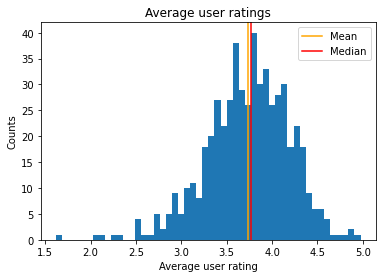

Minimum: 1.619047619047619
25th Percentile: 3.444915254237288
Median: 3.770127118644068
Mean: 3.7315660751297153
75th Percentile: 4.05
Maximum: 4.975


In [23]:
#ratings_averages, dummy = user_avg(ratings, False)

"""
ratings_averages["movieAvg"] = 0.0    
for movie in tqdm(ratings_averages.movieId.unique()):
    rating = np.mean(ratings_averages[ratings_averages["movieId"] == movie]["rating"])
    ratings_averages.loc[ratings_averages.movieId == movie, ["movieAvg"]] = rating
"""
ratings_averages = pd.DataFrame()
ratings_averages["userId"] = ratings.userId.unique()

data = ratings.pivot(index = "userId", columns = "movieId", values = "rating")
    # Get the movie averages
ratings_averages["userAvg"] = 0.0
#print("Combining data")
averages = data.mean(axis = 1, numeric_only = True)
for user in tqdm(data.index.values):
    ratings_averages.loc[ratings_averages.userId == user, ["userAvg"]] = averages[user]
        
del data

y = ratings_averages.userAvg

mean = np.mean(y)
median = np.median(y)
maximum = np.max(y)
minimum = np.min(y)
q1 = np.percentile(y, 25, interpolation = 'midpoint')
q3 = np.percentile(y, 75, interpolation = 'midpoint')

plt.hist(y, bins = 50)
plt.axvline(x=mean, color = "orange", label="Mean")
plt.axvline(x=median, color = "red", label = "Median")
plt.title("Average user ratings")
plt.xlabel("Average user rating")
plt.ylabel("Counts")
plt.legend(loc="upper right")
plt.savefig("avg_user_ratings.jpg")
plt.show()

print("Minimum:", minimum)
print("25th Percentile:", q1)
print("Median:", median)
print("Mean:", mean)
print("75th Percentile:", q3)
print("Maximum:", maximum)

100%|███████████████████████████████████████████████████████████████████████████████| 549/549 [00:01<00:00, 449.81it/s]


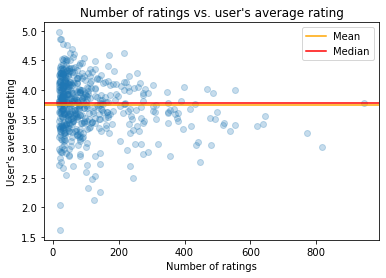

Minimum: 1.619047619047619
25th Percentile: 3.444915254237288
Median: 3.770127118644068
Mean: 3.7315660751297153
75th Percentile: 4.05
Maximum: 4.975


In [24]:
#ratings_averages, dummy = user_avg(ratings, False)

"""
ratings_averages["movieAvg"] = 0.0    
for movie in tqdm(ratings_averages.movieId.unique()):
    rating = np.mean(ratings_averages[ratings_averages["movieId"] == movie]["rating"])
    ratings_averages.loc[ratings_averages.movieId == movie, ["movieAvg"]] = rating
"""
ratings_averages = pd.DataFrame()
ratings_averages["userId"] = ratings.userId.unique()

data = ratings.pivot(index = "userId", columns = "movieId", values = "rating")
    # Get the movie averages
ratings_averages["userAvg"] = 0.0
ratings_averages["numRatings"] = 0
#print("Combining data")
averages = data.mean(axis = 1, numeric_only = True)
counts = data.count(axis = 1, numeric_only = True)
for user in tqdm(data.index.values):
    ratings_averages.loc[ratings_averages.userId == user, ["userAvg"]] = averages[user]
    ratings_averages.loc[ratings_averages.userId == user, ["numRatings"]] = counts[user]
        
del data

x = ratings_averages.numRatings
y = ratings_averages.userAvg


mean = np.mean(y)
median = np.median(y)
maximum_user = np.max(y)
minimum = np.min(y)
q1 = np.percentile(y, 25, interpolation = 'midpoint')
q3 = np.percentile(y, 75, interpolation = 'midpoint')


plt.scatter(x, y, alpha=0.25)
plt.axhline(y=mean, color = "orange", label="Mean")
plt.axhline(y=median, color = "red", label = "Median")
plt.title("Number of ratings vs. user's average rating")
plt.xlabel("Number of ratings")
plt.ylabel("User's average rating")
plt.legend(loc="upper right")
plt.savefig("num_user_ratings_vs_avg.jpg")
plt.show()

print("Minimum:", minimum)
print("25th Percentile:", q1)
print("Median:", median)
print("Mean:", mean)
print("75th Percentile:", q3)
print("Maximum:", maximum_user)

100%|█████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 435.40it/s]


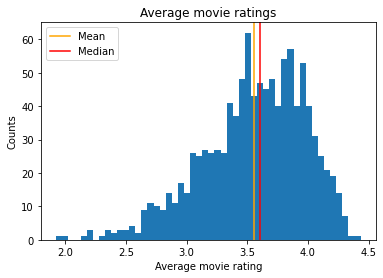

Minimum: 1.9259259259259258
25th Percentile: 3.3077651515151514
Median: 3.6029411764705883
Mean: 3.5558863590568572
75th Percentile: 3.870669056152927
Maximum: 4.432258064516129


In [25]:
ratings_averages = pd.DataFrame()
ratings_averages["movieId"] = ratings.movieId.unique()

data = ratings.pivot(index = "userId", columns = "movieId", values = "rating")

ratings_averages["movieAvg"] = 0.0
ratings_averages["numRatings"] = 0
averages = data.mean(axis = 0, numeric_only = True)
counts = data.count(axis = 0, numeric_only = True)
for movie in tqdm(ratings_averages.movieId):
    ratings_averages.loc[ratings_averages.movieId == movie, ["movieAvg"]] = averages[movie]
    ratings_averages.loc[ratings_averages.movieId == movie, ["numRatings"]] = counts[movie]
        
del data

y = ratings_averages.movieAvg

mean = np.mean(y)
median = np.median(y)
maximum = np.max(y)
minimum = np.min(y)
q1 = np.percentile(y, 25, interpolation = 'midpoint')
q3 = np.percentile(y, 75, interpolation = 'midpoint')

plt.hist(y, bins = 50)
plt.axvline(x=mean, color = "orange", label="Mean")
plt.axvline(x=median, color = "red", label = "Median")
plt.title("Average movie ratings")
plt.xlabel("Average movie rating")
plt.ylabel("Counts")
plt.legend(loc="upper left")
plt.savefig("avg_movie_ratings.jpg")
plt.show()

print("Minimum:", minimum)
print("25th Percentile:", q1)
print("Median:", median)
print("Mean:", mean)
print("75th Percentile:", q3)
print("Maximum:", maximum)

100%|█████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 417.23it/s]


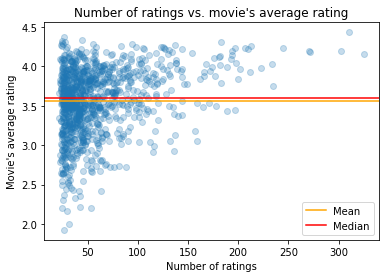

Minimum: 1.9259259259259258
25th Percentile: 3.3077651515151514
Median: 3.6029411764705883
Mean: 3.5558863590568572
75th Percentile: 3.870669056152927
Maximum: 4.432258064516129


In [26]:
ratings_averages = pd.DataFrame()
ratings_averages["movieId"] = ratings.movieId.unique()

data = ratings.pivot(index = "userId", columns = "movieId", values = "rating")

ratings_averages["movieAvg"] = 0.0
ratings_averages["numRatings"] = 0
averages = data.mean(axis = 0, numeric_only = True)
counts = data.count(axis = 0, numeric_only = True)
for movie in tqdm(ratings_averages.movieId):
    ratings_averages.loc[ratings_averages.movieId == movie, ["movieAvg"]] = averages[movie]
    ratings_averages.loc[ratings_averages.movieId == movie, ["numRatings"]] = counts[movie]
        
del data

x = ratings_averages.numRatings
y = ratings_averages.movieAvg


mean = np.mean(y)
median = np.median(y)
maximum_user = np.max(y)
minimum = np.min(y)
q1 = np.percentile(y, 25, interpolation = 'midpoint')
q3 = np.percentile(y, 75, interpolation = 'midpoint')


plt.scatter(x, y, alpha=0.25)
plt.axhline(y=mean, color = "orange", label="Mean")
plt.axhline(y=median, color = "red", label = "Median")
plt.title("Number of ratings vs. movie's average rating")
plt.xlabel("Number of ratings")
plt.ylabel("Movie's average rating")
plt.legend(loc="lower right")
plt.savefig("num_movie_ratings_vs_avg.jpg")
plt.show()

print("Minimum:", minimum)
print("25th Percentile:", q1)
print("Median:", median)
print("Mean:", mean)
print("75th Percentile:", q3)
print("Maximum:", maximum_user)

# Baselines

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

## Classification Baselines

In [28]:
y_val = copy.deepcopy(validation_removed['rating']) 
y_val = np.ravel(y_val)
y_val = pd.cut(y_val, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

y_test = copy.deepcopy(test_removed['rating']) 
y_test = np.ravel(y_test)
y_test = pd.cut(y_test, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

### Validation Baselines

In [29]:
# Baseline user average
ratings_pred = validation_removed.copy(deep=True)

for user in tqdm(training_validation["userId"].unique()):
    ratings_pred.loc[ratings_pred["userId"] == user, ["rating"]] = np.digitize(training_validation.loc[training_validation.userId == user, "userAvg"].iat[0], bins=[3], right = False)

avg_user_accuracy = accuracy_score(y_val, ratings_pred["rating"])
print("Baseline Validation Accuracy for user avg: %.2f%%" % (avg_user_accuracy * 100))

# Baseline movie average
ratings_pred = validation_removed.copy(deep=True)
training_movies = training_validation.movieId.unique()

for movie in tqdm(validation_removed.movieId.unique()):
    if movie in training_movies:
        ratings_pred.loc[ratings_pred.movieId == movie, ["rating"]] = np.digitize(training_validation.loc[training_validation.movieId == movie, "movieAvg"].iat[0], bins=[3], right = False)
    # If this movie happens to not be in the training data, simply assign a 0 (not like)
    else:
        ratings_pred.loc[ratings_pred.movieId == movie, ["rating"]] = 0
    
avg_movie_accuracy = accuracy_score(y_val, ratings_pred["rating"])
print("Baseline Test Accuracy for movie avg: %.2f%%" % (avg_movie_accuracy * 100))

  9%|███████▍                                                                        | 51/550 [00:00<00:00, 506.13it/s]

Baseline Validation Accuracy for user avg: 71.82%


100%|███████████████████████████████████████████████████████████████████████████████| 550/550 [00:00<00:00, 574.45it/s]

Baseline Test Accuracy for movie avg: 72.16%


### Test Baselines

In [30]:
# Baseline user average
ratings_pred = test_removed.copy(deep=True)

for user in tqdm(training_test["userId"].unique()):
    ratings_pred.loc[ratings_pred["userId"] == user, ["rating"]] = np.digitize(training_test.loc[training_test.userId == user, "userAvg"].iat[0], bins=[3], right = False)

baseline_avg_user_accuracy = accuracy_score(y_test, ratings_pred["rating"])
print("Baseline Test Accuracy for user avg: %.2f%%" % (baseline_avg_user_accuracy * 100))

# Baseline movie average
ratings_pred = test_removed.copy(deep=True)
training_movies = training_test.movieId.unique()

for movie in tqdm(test_removed.movieId.unique()):
    if movie in training_movies:
        ratings_pred.loc[ratings_pred.movieId == movie, ["rating"]] = np.digitize(training_test.loc[training_test.movieId == movie, "movieAvg"].iat[0], bins=[3], right = False)
    # If this movie happens to not be in the training data, simply assign a 0 (not like)
    else:
        ratings_pred.loc[ratings_pred.movieId == movie, ["rating"]] = 0

baseline_avg_movie_accuracy = accuracy_score(y_test, ratings_pred["rating"])
print("Baseline Test Accuracy for movie avg: %.2f%%" % (baseline_avg_movie_accuracy * 100))

 21%|████████████████▍                                                              | 129/620 [00:00<00:00, 638.32it/s]

Baseline Test Accuracy for user avg: 69.73%


100%|███████████████████████████████████████████████████████████████████████████████| 620/620 [00:01<00:00, 587.24it/s]

Baseline Test Accuracy for movie avg: 70.00%


## Regression Baselines

In [31]:
y_val = copy.deepcopy(validation_removed['rating']) 
y_val = np.ravel(y_val)

y_test = copy.deepcopy(test_removed['rating']) 
y_test = np.ravel(y_test)

### Validation Baselines

In [32]:
# Baseline user average
ratings_pred = validation_removed.copy(deep=True)
for user in tqdm(validation_removed.userId.unique()):
    ratings_pred.loc[ratings_pred["userId"] == user, ["rating"]] = training_validation.loc[training_validation.userId == user, "userAvg"].iat[0]

avg_user_rmse = mean_squared_error(y_val, ratings_pred["rating"], squared = False)
print("Baseline Validation RMSE for user avg:", avg_user_rmse)

# Baseline movie average
ratings_pred = validation_removed.copy(deep=True)
training_movies = training_validation.movieId.unique()

for movie in tqdm(validation_removed.movieId.unique()):
    if movie in training_movies:
        ratings_pred.loc[ratings_pred.movieId == movie, ["rating"]] = training_validation.loc[training_validation.movieId == movie, "movieAvg"].iat[0]
    # If this movie happens to not be in the training data, simply assign a 0 (not like)
    else:
        ratings_pred.loc[ratings_pred.movieId == movie, ["rating"]] = 0
    
avg_movie_rmse = mean_squared_error(y_val, ratings_pred["rating"], squared = False)
print("Baseline Validation RMSE for movie avg:", avg_movie_rmse)

 22%|█████████████████▋                                                             | 123/550 [00:00<00:00, 609.49it/s]

Baseline Validation RMSE for user avg: 0.970671907398001


100%|███████████████████████████████████████████████████████████████████████████████| 550/550 [00:00<00:00, 616.00it/s]

Baseline Validation RMSE for movie avg: 0.9279114110631917


### Test Baselines

In [33]:
# Baseline user average
ratings_pred = test_removed.copy(deep=True)
for user in tqdm(training_test["userId"].unique()):
    ratings_pred.loc[ratings_pred["userId"] == user, ["rating"]] = training_test.loc[training_test.userId == user, "userAvg"].iat[0]

avg_user_rmse = mean_squared_error(y_test, ratings_pred["rating"], squared = False)
print("Baseline Test RMSE for user avg:", avg_user_rmse)

# Baseline movie average
ratings_pred = test_removed.copy(deep=True)
training_movies = training_test.movieId.unique()

for movie in tqdm(test_removed.movieId.unique()):
    if movie in training_movies:
        ratings_pred.loc[ratings_pred.movieId == movie, ["rating"]] = training_test.loc[training_test.movieId == movie, "movieAvg"].iat[0]
    # If this movie happens to not be in the training data, simply assign a 0 (not like)
    else:
        ratings_pred.loc[ratings_pred.movieId == movie, ["rating"]] = 0
    
avg_movie_rmse = mean_squared_error(y_test, ratings_pred["rating"], squared = False)
print("Baseline Test RMSE for movie avg:", avg_movie_rmse)

 20%|████████████████▏                                                              | 127/620 [00:00<00:00, 630.45it/s]

Baseline Test RMSE for user avg: 0.9830622358141182


100%|███████████████████████████████████████████████████████████████████████████████| 620/620 [00:01<00:00, 597.81it/s]

Baseline Test RMSE for movie avg: 1.0358683519569263


# Models

## Decision Tree

#### Classification Approach

In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.evaluate import bootstrap_point632_score

from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree


In [35]:
use_cols = ['userId', 'movieId', 'userAvg', 'movieAvg', 'timestamp']
use_cols.extend(genres)
x_train = copy.deepcopy(training_validation[use_cols].to_numpy())
y_train = copy.deepcopy(training_validation[['rating']])
y_train = np.ravel(y_train)
y_train = pd.cut(y_train, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

x_val = copy.deepcopy(validation_removed[use_cols].to_numpy())
y_val = copy.deepcopy(validation_removed['rating']) 
y_val = np.ravel(y_val)
y_val = pd.cut(y_val, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

In [36]:
# # use_cols = ['userId', 'movieId', 'userAvg', 'movieAvg', 'timestamp', 'numMovieRatings', 'numUserRatings']
# use_cols.extend(genres)
# x_train = copy.deepcopy(training_validation[use_cols].to_numpy())
# y_train = copy.deepcopy(training_validation[['rating']])
# y_train = np.ravel(y_train)
# y_train = pd.cut(y_train, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

# x_val = copy.deepcopy(validation_removed[use_cols].to_numpy())
# y_val = copy.deepcopy(validation_removed['rating']) 
# y_val = np.ravel(y_val)
# y_val = pd.cut(y_val, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

In [37]:
# %%time
import time
start=time.time()
"started training decision tree"

tree = DecisionTreeClassifier(random_state=123)
param_grid = {'max_depth':[3,4,5,6,7,8,9,10,15,20,None], 
              'criterion':['gini','entropy']} 

gs = GridSearchCV(estimator=tree,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1,
                  verbose=3)

gs.fit(x_train, y_train)
end=time.time()
print(end-start)

Fitting 10 folds for each of 22 candidates, totalling 220 fits
26.890082597732544


In [38]:
print('Best Params: %s' % gs.best_params_)
print('Best Validation Accuracy: %.2f%%' % (gs.best_score_*100))

Best Params: {'criterion': 'gini', 'max_depth': 4}
Best Validation Accuracy: 73.40%


In [39]:
# Fit best model on whole dataset and predict validation data
tree = DecisionTreeClassifier(**gs.best_params_, random_state=123)
tree.fit(x_train, y_train)

ratings_pred = tree.predict(x_val)
accuracy = accuracy_score(y_val, ratings_pred)
print('Validation Accuracy: %.2f%%' % (accuracy*100))

Validation Accuracy: 76.02%


In [40]:
feature_importance_values

NameError: name 'feature_importance_values' is not defined

In [ ]:
feature_importance_values = tree.feature_importances_
feature_importances = pd.Series(feature_importance_values, index=training_validation[use_cols].columns) # x train's column values
feature_top = feature_importances.sort_values(ascending=False)

plt.figure(figsize=[8, 6])
plt.title('Feature Importances')
sns.barplot(x=feature_top, y=feature_top.index)
plt.savefig('tree_feature_importances.jpg', dpi=200)
plt.show()

- movieAverage was the most important feature in the prediction model
    - movie's quality/social standard in general affects individuals' rate 
- userAverage was the second > so each person's rating standard/rating tendancy affects actual rate
    - someone could send out 0 for dislike and 3 or like but someone else could send 5 for all movies
    
- timestamp represents seconds that have elapsed since the Unix epoch 00:00:00 UTC on midnight UTC of Janurary 1, 1970
    - https://en.wikipedia.org/wiki/Unix_time
    - Thus when the movie was watched also affects the rate
    
- genres in the other hand doesn't significantly affect the rate 

diagram

In [ ]:
best_tree = DecisionTreeClassifier(max_depth=4, criterion='gini')
best_tree.fit(x_train, y_train)

plt.figure(figsize=(10, 7))

plot_tree(best_tree, 
          filled=True, 
          rounded=True,
          class_names=['0', 
                       '1'],
          feature_names=training_test[use_cols].columns) 
plt.savefig('tree_diagram.png', dpi=200)
plt.show()

In [ ]:
# Fit best model on whole dataset and predict test data
x_train = copy.deepcopy(training_test[use_cols].to_numpy())

y_train = copy.deepcopy(training_test[['rating']])
y_train = np.ravel(y_train)
y_train = pd.cut(y_train, bins=[0,3,5], labels=[0,1])

x_test = copy.deepcopy(test_removed[use_cols].to_numpy())
y_test = copy.deepcopy(test_removed['rating']) 

y_test = np.ravel(y_test)
y_test = pd.cut(y_test, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

tree = DecisionTreeClassifier(**gs.best_params_, random_state=123)
tree.fit(x_train, y_train)

ratings_pred = tree.predict(x_test)
tree_test_accuracy = accuracy_score(y_test, ratings_pred)
print('Test Accuracy: %.2f%%' % (tree_test_accuracy*100))

#### Regression Approach

In [ ]:
use_cols = ['userId', 'movieId', 'userAvg', 'movieAvg', 'timestamp', 'numMovieRatings', 'numUserRatings']
use_cols.extend(genres)
x_train = copy.deepcopy(training_validation[use_cols].to_numpy())
y_train = copy.deepcopy(training_validation[['rating']])
y_train = np.ravel(y_train)

x_val = copy.deepcopy(validation_removed[use_cols].to_numpy())
y_val = copy.deepcopy(validation_removed['rating']) 
y_val = np.ravel(y_val)

In [ ]:
tree = DecisionTreeRegressor(random_state=123)
param_grid = {'max_depth':[3,4,5,6,7,8,9,10,15,20,None]} 

gs = GridSearchCV(estimator=tree,
                  param_grid=param_grid,
                  scoring='neg_root_mean_squared_error',
                  cv=10,
                  n_jobs=-1,
                  verbose=3)

gs.fit(x_train, y_train)

In [ ]:
print('Best Params:',  gs.best_params_)
print('Best Validation RMSE:', -1 * gs.best_score_)

In [ ]:
# Fit best model on whole dataset and predict validation data
tree = DecisionTreeRegressor(**gs.best_params_, random_state=123)
tree.fit(x_train, y_train)

ratings_pred = tree.predict(x_val)
rmse = mean_squared_error(y_val, ratings_pred, squared = False)
print('Validation RMSE:', rmse)

In [ ]:
# Fit best model on whole dataset and predict test data
x_train = copy.deepcopy(training_test[use_cols].to_numpy())
y_train = copy.deepcopy(training_test[['rating']])
y_train = np.ravel(y_train)

x_test = copy.deepcopy(test_removed[use_cols].to_numpy())
y_test = copy.deepcopy(test_removed['rating']) 
y_test = np.ravel(y_test)

tree = DecisionTreeRegressor(**gs.best_params_, random_state=123)
tree.fit(x_train, y_train)

ratings_pred = tree.predict(x_test)
rmse = mean_squared_error(y_test, ratings_pred, squared = False)
print('Test RMSE:', rmse)

## Random Forest

#### Classification Approach

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
use_cols = ['userId', 'movieId', 'userAvg', 'movieAvg', 'timestamp', 'numMovieRatings', 'numUserRatings']
use_cols.extend(genres)
x_train = copy.deepcopy(training_validation[use_cols].to_numpy())
y_train = copy.deepcopy(training_validation[['rating']])
y_train = np.ravel(y_train)
y_train = pd.cut(y_train, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

x_val = copy.deepcopy(validation_removed[use_cols].to_numpy())
y_val = copy.deepcopy(validation_removed['rating']) 
y_val = np.ravel(y_val)
y_val = pd.cut(y_val, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

In [ ]:
"""
clf = RandomForestClassifier(random_state=1)
param_grid = {'n_estimators':[10, 20, 50, 100, 200, 300, 400, 500, 1000], 
              'criterion':['gini','entropy']} 

gs = GridSearchCV(estimator=clf,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1,
                  verbose=3)

gs.fit(x_train, y_train)
"""

In [ ]:
#print('Best Params: %s' % gs.best_params_)
#print('Best Validation Accuracy: %.2f%%' % (gs.best_score_*100))

In [ ]:
# Fit best model on whole dataset and predict validation data
#clf = RandomForestClassifier(**gs.best_params_, random_state=1)
use_cols = ['userId', 'movieId', 'userAvg', 'movieAvg', 'timestamp', 'numMovieRatings', 'numUserRatings']
use_cols.extend(genres)
x_train = copy.deepcopy(training_validation[use_cols].to_numpy())
y_train = copy.deepcopy(training_validation[['rating']])
y_train = np.ravel(y_train)
y_train = pd.cut(y_train, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

x_val = copy.deepcopy(validation_removed[use_cols].to_numpy())
y_val = copy.deepcopy(validation_removed['rating']) 
y_val = np.ravel(y_val)
y_val = pd.cut(y_val, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

clf = RandomForestClassifier(criterion = "entropy", n_estimators = 500, random_state=1)
clf.fit(x_train, y_train)

ratings_pred = clf.predict(x_val)
accuracy = accuracy_score(y_val, ratings_pred)
print('Validation Accuracy: %.2f%%' % (accuracy*100))

In [ ]:
feature_importance_values = clf.feature_importances_
feature_importances = pd.Series(feature_importance_values, index=training_validation[use_cols].columns) # x train's column values
feature_top = feature_importances.sort_values(ascending=False)

plt.figure(figsize=[8, 6])
plt.title('Feature Importances')
sns.barplot(x=feature_top, y=feature_top.index)
plt.show()

- movieAverage was the most important feature in the prediction model
    - movie's quality/social standard in general affects individuals' rate 
- userAverage was the second > so each person's rating standard/rating tendancy affects actual rate
    - someone could send out 0 for dislike and 3 or like but someone else could send 5 for all movies
    
- timestamp represents seconds that have elapsed since the Unix epoch 00:00:00 UTC on midnight UTC of Janurary 1, 1970
    - https://en.wikipedia.org/wiki/Unix_time
    - Thus when the movie was watched also affects the rate
    
- genres in the other hand doesn't significantly affect the rate 

In [ ]:
# Fit best model on whole dataset and predict test data
x_train = copy.deepcopy(training_test[use_cols].to_numpy())

y_train = copy.deepcopy(training_test[['rating']])
y_train = np.ravel(y_train)
y_train = pd.cut(y_train, bins=[0,3,5], labels=[0,1])

x_test = copy.deepcopy(test_removed[use_cols].to_numpy())
y_test = copy.deepcopy(test_removed['rating']) 

y_test = np.ravel(y_test)
y_test = pd.cut(y_test, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

#clf = RandomForestClassifier(**gs.best_params_, random_state=123)
clf = RandomForestClassifier(criterion = "entropy", n_estimators = 500, random_state=1)
clf.fit(x_train, y_train)

ratings_pred = clf.predict(x_test)
rf_test_accuracy = accuracy_score(y_test, ratings_pred)
print('Test Accuracy: %.2f%%' % (rf_test_accuracy*100))

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from xgboost import XGBRegressor

### Classification Approach

In [ ]:
# Fit best model on whole dataset and predict validation data
use_cols = ['userId', 'movieId', 'userAvg', 'movieAvg', 'timestamp', 'numMovieRatings', 'numUserRatings']
use_cols.extend(genres)
x_train = copy.deepcopy(training_validation[use_cols].to_numpy())

y_train = copy.deepcopy(training_validation[['rating']])
y_train = np.ravel(y_train)
y_train = pd.cut(y_train, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

x_val = copy.deepcopy(validation_removed[use_cols].to_numpy())

y_val = copy.deepcopy(validation_removed['rating']) 
y_val = np.ravel(y_val)
y_val = pd.cut(y_val, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

clf = XGBClassifier(gamma = 5, reg_lambda = 0, eval_metric = 'logloss', eta=0.07, max_depth=5, min_child_weight = 4, n_estimators = 216, subsample = 0.70, n_jobs=-1, random_state=1, use_label_encoder = False)
clf.fit(x_train, y_train)

ratings_pred = clf.predict(x_val)
accuracy = accuracy_score(y_val, ratings_pred)
print('Validation Accuracy: %.2f%%' % (accuracy*100))

In [ ]:
feature_importance_values = clf.feature_importances_
feature_importances = pd.Series(feature_importance_values, index=training_validation[use_cols].columns) # x train's column values
feature_top = feature_importances.sort_values(ascending=False)

plt.figure(figsize=[8, 6])
plt.title('Feature Importances')
sns.barplot(x=feature_top, y=feature_top.index)
plt.show()

- movieAverage was the most important feature in the prediction model
    - movie's quality/social standard in general affects individuals' rate 
- userAverage was the second > so each person's rating standard/rating tendancy affects actual rate
    - someone could send out 0 for dislike and 3 or like but someone else could send 5 for all movies
    
- timestamp represents seconds that have elapsed since the Unix epoch 00:00:00 UTC on midnight UTC of Janurary 1, 1970
    - https://en.wikipedia.org/wiki/Unix_time
    - Thus when the movie was watched also affects the rate
    
- genres in the other hand doesn't significantly affect the rate 

In [ ]:
# Fit best model on whole dataset and predict test data
x_train = copy.deepcopy(training_test[use_cols].to_numpy())

y_train = copy.deepcopy(training_test[['rating']])
y_train = np.ravel(y_train)
y_train = pd.cut(y_train, bins=[0,3,5], labels=[0,1])

x_test = copy.deepcopy(test_removed[use_cols].to_numpy())
y_test = copy.deepcopy(test_removed['rating']) 

y_test = np.ravel(y_test)
y_test = pd.cut(y_test, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

clf = XGBClassifier(gamma = 5, reg_lambda = 0, eval_metric = 'logloss', eta = 0.07, max_depth = 5, min_child_weight = 4, n_estimators = 216, subsample = 0.70, n_jobs=-1, random_state=1, use_label_encoder = False)
clf.fit(x_train, y_train)

ratings_pred = clf.predict(x_test)
xgb_test_accuracy = accuracy_score(y_test, ratings_pred)
print('Test Accuracy: %.2f%%' % (xgb_test_accuracy*100))

### Regression Approach

In [ ]:
# Fit best model on whole dataset and predict validation data
use_cols = ['userId', 'movieId', 'userAvg', 'movieAvg', 'timestamp', 'numMovieRatings', 'numUserRatings']
use_cols.extend(genres)
x_train = copy.deepcopy(training_validation[use_cols].to_numpy())

y_train = copy.deepcopy(training_validation[['rating']])
y_train = np.ravel(y_train)

x_val = copy.deepcopy(validation_removed[use_cols].to_numpy())
y_val = copy.deepcopy(validation_removed['rating']) 
y_val = np.ravel(y_val)

clf = XGBRegressor(eval_metric = 'logloss', eta=0.1, max_depth=5, min_child_weight = 4, n_estimators = 216, subsample = 0.70, n_jobs=-1, random_state=1, use_label_encoder = False)
clf.fit(x_train, y_train)

ratings_pred = clf.predict(x_val)
rmse = mean_squared_error(y_val, ratings_pred, squared = False)
print('Validation RMSE:', rmse)

In [ ]:
# Fit best model on whole dataset and predict validation data
x_train = copy.deepcopy(training_test[use_cols].to_numpy())
y_train = copy.deepcopy(training_test[['rating']])
y_train = np.ravel(y_train)

x_test = copy.deepcopy(test_removed[use_cols].to_numpy())
y_test = copy.deepcopy(test_removed['rating']) 
y_test = np.ravel(y_test)

clf = XGBRegressor(eval_metric = 'logloss', eta=0.1, max_depth=5, min_child_weight = 4, n_estimators = 200, subsample = 0.70, n_jobs=-1, random_state=1, use_label_encoder = False)
clf.fit(x_train, y_train)

ratings_pred = clf.predict(x_test)
rmse = mean_squared_error(y_test, ratings_pred, squared = False)
print('Test RMSE:', rmse)

## KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier
use_cols = ['userAvg', 'movieAvg']

x_train = copy.deepcopy(training_validation[use_cols].to_numpy())

y_train = copy.deepcopy(training_validation[['rating']])
y_train = np.ravel(y_train)
y_train = pd.cut(y_train, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

x_val = copy.deepcopy(validation_removed[use_cols].to_numpy())

y_val = copy.deepcopy(validation_removed['rating']) 
y_val = np.ravel(y_val)
y_val = pd.cut(y_val, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

In [42]:
# Find the best KNN model on the validation data for Ks 1 - 50
best_k = 0
highest_accuracy = 0
accuracies = list()
for k in tqdm(range(1,101)):
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(x_train, y_train)

    ratings_pred = knn.predict(x_val)
    accuracy = accuracy_score(y_val, ratings_pred)
    accuracies.append(accuracy)
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        best_k = k
print("The best K was", best_k, "with an accuracy of %.2f%%" % (highest_accuracy*100))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.88it/s]

The best K was 77 with an accuracy of 76.82%


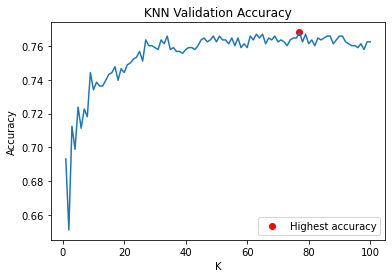

In [43]:
plt.title("KNN Validation Accuracy")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.scatter(best_k, highest_accuracy, color = "red", label = "Highest accuracy")
plt.legend(loc="lower right")
plt.savefig("knn_val_accuracy.jpg")
plt.plot(range(1, 101), accuracies)

In [44]:
# Fit a model with the best value of K for the validation set on the test data
x_train = copy.deepcopy(training_test[use_cols].to_numpy())

y_train = copy.deepcopy(training_test[['rating']])
y_train = np.ravel(y_train)
y_train = pd.cut(y_train, bins=[0,3,5], labels=[0,1])

x_test = copy.deepcopy(test_removed[use_cols].to_numpy())
y_test = copy.deepcopy(test_removed['rating']) 

y_test = np.ravel(y_test)
y_test = pd.cut(y_test, bins=[0,3,5], labels=[0,1]) # convert continuous to categorical

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(x_train, y_train)

ratings_pred = knn.predict(x_test)
knn_test_accuracy = accuracy_score(y_test, ratings_pred)
print('k='+str(best_k)+' Test Accuracy: %.2f%%' % (knn_test_accuracy*100))

k=77 Test Accuracy: 75.27%


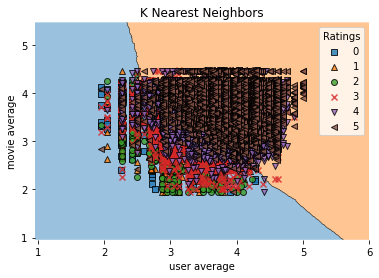

In [54]:
from mlxtend.plotting import plot_decision_regions
y_t= training_test[['rating']].values.flatten()
x_t= training_test[use_cols].to_numpy()
plot_decision_regions(x_t,y_t.astype(np.int_), best_knn)

plt.title("K Nearest Neighbors")
plt.xlabel('user average')
plt.ylabel('movie average')
legend = plt.legend(title="Ratings")
plt.savefig("knn_diagram.jpg")

# Model Comparison

In [ ]:
x = ["Baseline User Average", "Baseline Movie Average", "XGBoost", "Decision Tree", "KNN", "Random Forest"]
y = [baseline_avg_user_accuracy, baseline_avg_movie_accuracy, xgb_test_accuracy, tree_test_accuracy, knn_test_accuracy, rf_test_accuracy]

def get_key(item):
    return item[1]
x, y = zip(*sorted(zip(x, y), reverse = False, key = get_key))

plt.figure(facecolor="#FFFFFF")
plt.xlim(0.5, 0.8)
plt.barh(x, y)
plt.title("Test Set Accuracy by Model")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.savefig("model_test_accuracies.jpg")
plt.show()